<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-LH-1169213/blob/main/TecMty_kmeans_targetA01169213.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresiones y Kmeans
## EJERCICIO: Kmeans
## Laura Elena Hernández Mata
## A01169213
### Ciencia y analítica de datos (TC4029.10)
### Dra. María de la Paz Rico Fernández

9 noviembre 2022
Semana 8

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [13]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [15]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [16]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [18]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

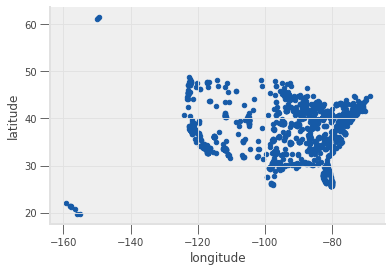

In [19]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [20]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [22]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [23]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [24]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [25]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

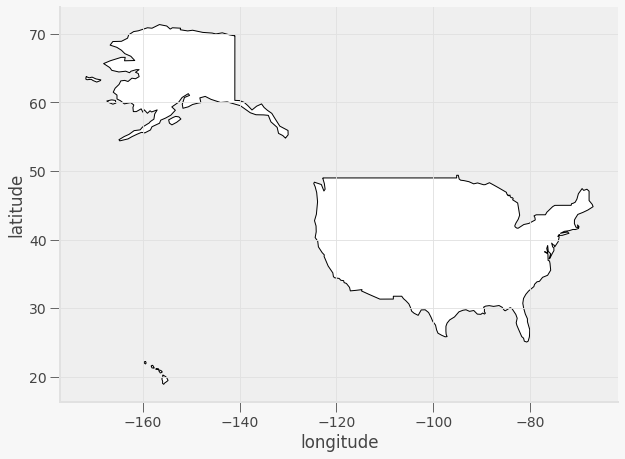

In [26]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

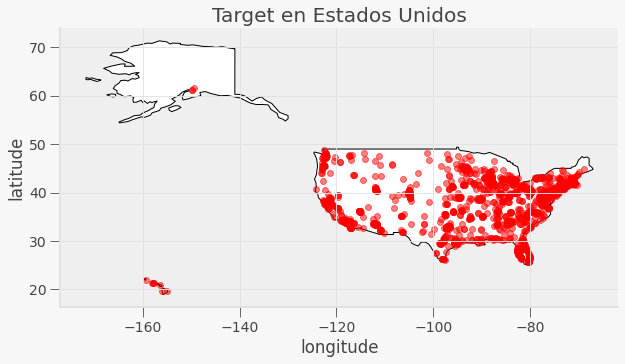

In [27]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

INSTRUCCIONES

Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber dónde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

Encuentra el numero ideal de almacenes, justifica tu respuesta:

Encuentra las latitudes y longitudes de los almacenes, ¿qué ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estará?
¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente.

Adicionalmente, en el notebook notaras que al inicio exploramos los datos y los graficamos de manera simple, después nos auxiliamos de una librería de datos geográficos.

¿qué librerías nos pueden ayudar a graficar este tipo de datos?
¿Consideras importante que se grafique en un mapa?, ¿por qué?
Agrega las conclusiones

In [28]:
from sklearn.cluster import KMeans

# CLUSTERIZACIÓN

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = latlong[['latitude']]
X_axis = latlong[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

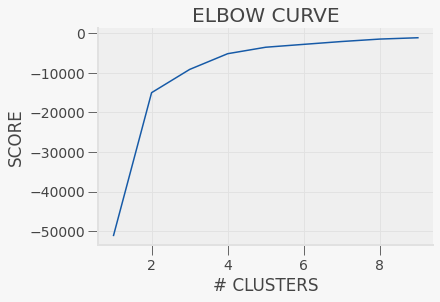

In [29]:
# GRAFICAMOS

plt.plot(K_clusters, score)
plt.xlabel('# CLUSTERS')
plt.ylabel('SCORE')
plt.title('ELBOW CURVE')
plt.show()


¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente. [PARTE 1]

*En la gráfica de codos se muestra que a partir del 3er almacén la curva se acerca mucho al cero, y la cantidad de tiendas entre el tercer y el cuarto almacén podría no justificar a nivel negocio la inversión en costos fijos y variables de incluirlo. Sin embargo, decidí ensayar con ambas opciones para verificar la mejor opción, como se muestra a continuación.* 

3 almacenes:

In [30]:
# OPCIÓN DE 3 ALMACENES

kmeans = KMeans(n_clusters = 3, init ='k-means++') 
kmeans.fit(latlong[latlong.columns[0:2]])

labels = kmeans.labels_
labels

array([2, 2, 2, ..., 0, 2, 0], dtype=int32)

In [31]:
# REALIZAMOS CÁLCULOS PARA OBTENER LAS COORDENADAS

X = df[["longitude","latitude"]]

kmeans = KMeans(n_clusters=3).fit(X) 
centroids = kmeans.cluster_centers_ 
labels = kmeans.predict(X) 

C = kmeans.cluster_centers_

C_DF = pd.DataFrame(C) 
C_DF["Coordinates"] = list(zip(C_DF[0], C_DF[1])) 
C_DF["Coordinates"] = C_DF["Coordinates"].apply(Point) 


gdf_C = gpd.GeoDataFrame(C_DF, geometry="Coordinates") 
gdf_C

,0,1,Coordinates
0,-93.291756,37.987411,POINT (-93.29176 37.98741)
1,-118.624473,37.487342,POINT (-118.62447 37.48734)
2,-78.543258,37.783242,POINT (-78.54326 37.78324)


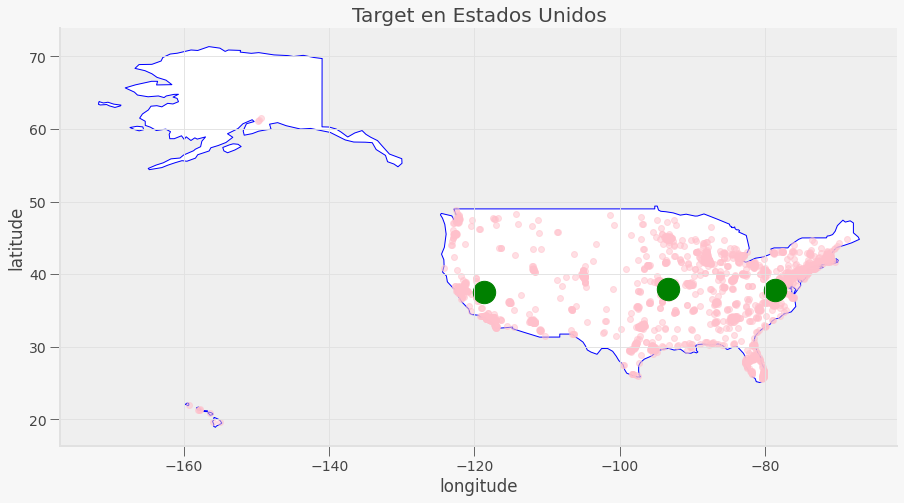

In [34]:
# GRAFICAMOS EN EL MAPA

fig, gax = plt.subplots(figsize=(15,10))

world.query("name == 'United States of America'").plot(ax = gax, edgecolor='blue', color='white')

gdf.plot(ax=gax, color='pink', alpha = 0.5) 
gdf_C.plot(ax=gax, color='green', alpha = 1, markersize = 500) 

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [35]:
# TIENDAS A LAS CUALES VA A SURTIR 

latlong['kmeans'] = kmeans.labels_  
latlong.loc[:, 'kmeans'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2    826
0    628
1    385
Name: kmeans, dtype: int64

In [36]:
gdf_C

,0,1,Coordinates
0,-93.291756,37.987411,POINT (-93.29176 37.98741)
1,-118.624473,37.487342,POINT (-118.62447 37.48734)
2,-78.543258,37.783242,POINT (-78.54326 37.78324)


In [37]:
# OBTENEMOS LA GEOLOCALIZACIÓN

from pandas.core.internals.concat import concat_arrays

Location1 = str(gdf_C[1][0]) + ", " + str(gdf_C[0][0]) 
print(Location1)
Location2 = str(gdf_C[1][1]) + ", " + str(gdf_C[0][1])
print(Location2)
Location3 = str(gdf_C[1][2]) + ", " + str(gdf_C[0][2])
print(Location3)

37.98741063, -93.29175635730158
37.48734203064935, -118.62447331844157
37.78324237706311, -78.54325789757283


In [40]:
# DETERMINAMOS LA UBICACIÓN

from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim 
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="my-application") 
Locations = [Location1, Location2, Location3] 

for i in Locations:
  location = geolocator.reverse(i)  
  print('Almacén en ---', location.address)

Almacén en --- Turkey Hollow Road, Hickory County, Missouri, United States
Almacén en --- Paradise Estates, Mono County, California, United States
Almacén en --- James River Road, Scottsville, Albemarle County, Virginia, 24590, United States


In [42]:
# CALCULAMOS LAS DISTANCIAS

distancia1 = str(geodesic(Location1, Location2).miles)
print("\nDistancia entre el primer y segundo almacén : ", distancia1, " ft2 \n") 
distancia2 = str(geodesic(Location2, Location3).miles)
print("Distancia entre el segundo y tercer almacén : ", distancia2, " ml \n")



Distancia entre el primer y segundo almacén :  1383.6240351318138  ft2 

Distancia entre el segundo y tercer almacén :  2181.1718442442752  ml 



4 almacenes

In [43]:
kmeans = KMeans(n_clusters = 4, init ='k-means++') 
kmeans.fit(latlong[latlong.columns[0:2]])

labels = kmeans.labels_
labels

array([0, 0, 0, ..., 2, 2, 1], dtype=int32)

In [44]:
# REALIZAMOS CÁLCULOS PARA OBTENER LAS COORDENADAS

X = df[["longitude","latitude"]]

kmeans = KMeans(n_clusters=4).fit(X) 
centroids = kmeans.cluster_centers_ 
labels = kmeans.predict(X) 

C = kmeans.cluster_centers_

C_DF = pd.DataFrame(C) 
C_DF["Coordinates"] = list(zip(C_DF[0], C_DF[1])) 
C_DF["Coordinates"] = C_DF["Coordinates"].apply(Point) 


gdf_C = gpd.GeoDataFrame(C_DF, geometry="Coordinates") 
gdf_C

,0,1,Coordinates
0,-84.821801,36.561016,POINT (-84.82180 36.56102)
1,-119.146456,37.577577,POINT (-119.14646 37.57758)
2,-75.275533,40.332247,POINT (-75.27553 40.33225)
3,-96.988056,36.990483,POINT (-96.98806 36.99048)


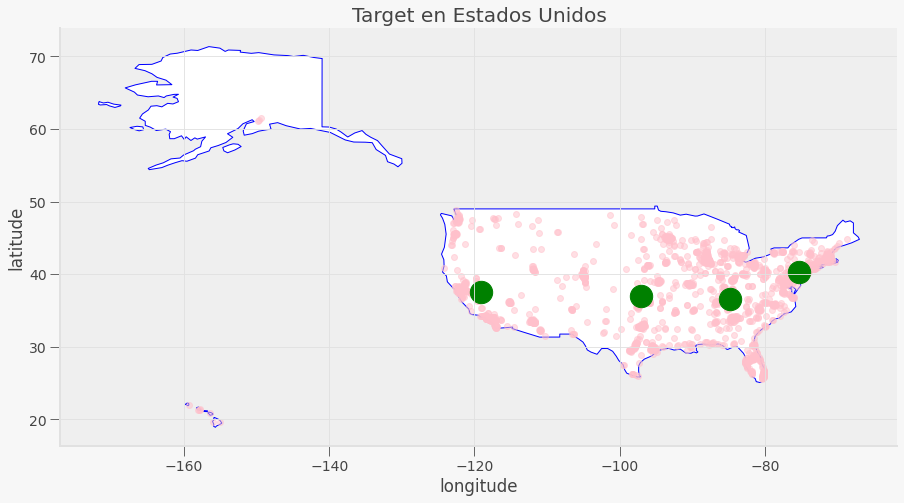

In [45]:
# GRAFICAMOS EN EL MAPA

fig, gax = plt.subplots(figsize=(15,10))

world.query("name == 'United States of America'").plot(ax = gax, edgecolor='blue', color='white')

gdf.plot(ax=gax, color='pink', alpha = 0.5) 
gdf_C.plot(ax=gax, color='green', alpha = 1, markersize = 500) 

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [46]:
# TIENDAS A LAS CUALES VA A SURTIR 

latlong['kmeans'] = kmeans.labels_  
latlong.loc[:, 'kmeans'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    615
2    454
3    401
1    369
Name: kmeans, dtype: int64

In [47]:
gdf_C

,0,1,Coordinates
0,-84.821801,36.561016,POINT (-84.82180 36.56102)
1,-119.146456,37.577577,POINT (-119.14646 37.57758)
2,-75.275533,40.332247,POINT (-75.27553 40.33225)
3,-96.988056,36.990483,POINT (-96.98806 36.99048)


In [49]:
# OBTENEMOS LA GEOLOCALIZACIÓN

from pandas.core.internals.concat import concat_arrays

Location1 = str(gdf_C[1][0]) + ", " + str(gdf_C[0][0]) 
print(Location1)
Location2 = str(gdf_C[1][1]) + ", " + str(gdf_C[0][1])
print(Location2)
Location3 = str(gdf_C[1][2]) + ", " + str(gdf_C[0][2])
print(Location3)
Location4 = str(gdf_C[1][3]) + ", " + str(gdf_C[0][3])
print(Location4)

36.561016371266234, -84.82180092435064
37.57757741219512, -119.14645561138212
40.33224701032967, -75.27553282527472
36.990482601253134, -96.98805592681704


In [50]:
# DETERMINAMOS LA UBICACIÓN

from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim 
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="my-application") 
Locations = [Location1, Location2, Location3, Location4] 

for i in Locations:
  location = geolocator.reverse(i)  
  print('Almacén en ---', location.address)

Almacén en --- John Muir Trail, Pickett County, Tennessee, United States
Almacén en --- Mammoth Trail, Madera County, California, United States
Almacén en --- Diamond Street, Hilltown Township, Bucks County, Pennsylvania, 18962, United States
Almacén en --- North Longwood Drive, Kay County, Oklahoma, United States


In [52]:
# CALCULAMOS LAS DISTANCIAS

distancia1 = str(geodesic(Location1, Location2).miles)
print("\nDistancia entre el primer y segundo almacén : ", distancia1, " ft2 \n") 
distancia2 = str(geodesic(Location2, Location3).miles)
print("Distancia entre el segundo y tercer almacén : ", distancia2, " ml \n")
distancia3 = str(geodesic(Location3, Location4).miles)
print("Distancia entre el tercer y cuarto almacén : ", distancia3, " ml \n")


Distancia entre el primer y segundo almacén :  1887.4531222784362  ft2 

Distancia entre el segundo y tercer almacén :  2346.3893796007856  ml 

Distancia entre el tercer y cuarto almacén :  1193.4922031176995  ml 



¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente. [PARTE 2]

*Tal como se apreciaba en la gráfica de codos al inicio de la actividad, la distancia en cantidades de tiendas entre 3 y 4 almacenes era pequeña. Esto fue comprobado a través del cálculo de 3 y 4 almacenes. Puedo observar que en el caso de 3 almacenes, la distribución de los puntos está homologada; mientras que cuando lo corrí para 4 almacenes, la distancia entre los del lado derecho es muy pequeña. A nivel modelo, considero que la mejor opción es la de 3 almacenes, ya que no se está sobreentrenando al mismo. Igualmente, a nivel negocio considero que un almacén adicional no sería justificable en tanto que esto representaría un gasto para la compañía en costos fijos y variables y operativamente no es necesario por lo que expliqué anteriormente.*

Encuentra las latitudes y longitudes de los almacenes, ¿qué ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estará?



*La mejor opción es la de 3 almacenes y las ciudades en las que se encontrarán son: Hickory County, Missouri; Mono County, California; y Albemarle County, Virginia. Van a surtir a 628, 385 y 826, respectivamente. La distancia entre éstos será de primer y segundo almacén :  1383.6240351318138  ft2; y  entre el segundo y tercer almacén :  2181.1718442442752  ml.*

¿Qué librerías nos pueden ayudar a graficar este tipo de datos? ¿Consideras importante que se grafique en un mapa?, ¿por qué?

*Creo que las librerías que me ayudaron fueron **"import geopandas as gpd"** y **"from shapely.geometry import Point"**, las cuales me permitieron colocar mapas y puntos y tener referencia visual del ejercicio. Otra que ya había utilizado anteriormente para histogramas, boxplot, etc es la de **"import matplotlib.pyplot as plt"**, la cual permite imprimir los mapas y demás gráficos.*

*Sí, pienso que es importante que se grafique en un mapa, ya que esto me permite visualizar la relación entre las tiendas y los almacenes, para este caso en particular. Inclusive, fue muy útil visualizarlo entre los 3 y 4 almacenes, ya que pude apreciar la relación entre éstos y comprender el impacto de incrementar en un almacén el modelo, esto porque los puntos estaban muy cerca y sin el mapa no hubiera sido posible.*